[*********************100%***********************]  1 of 1 completed

Price                      Adj Close      Close       High        Low  \
Ticker                       SOL-USD    SOL-USD    SOL-USD    SOL-USD   
Datetime                                                                
2023-11-24 00:00:00+00:00  57.112225  57.112225  57.151714  56.349091   
2023-11-24 01:00:00+00:00  57.043854  57.043854  57.483349  56.963634   
2023-11-24 02:00:00+00:00  57.269119  57.269119  57.323360  56.946457   
2023-11-24 03:00:00+00:00  57.319035  57.319035  57.435780  57.267445   
2023-11-24 04:00:00+00:00  57.250343  57.250343  57.356934  57.178703   

Price                           Open  Volume  
Ticker                       SOL-USD SOL-USD  
Datetime                                      
2023-11-24 00:00:00+00:00  56.578892       0  
2023-11-24 01:00:00+00:00  57.109486       0  
2023-11-24 02:00:00+00:00  57.042484       0  
2023-11-24 03:00:00+00:00  57.276073       0  
2023-11-24 04:00:00+00:00  57.319736       0  
Epoch 1/50



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0137 - val_loss: 8.2473e-04
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.9326e-04 - val_loss: 0.0014
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.1153e-04 - val_loss: 0.0011
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 5.0577e-04 - val_loss: 0.0019
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.4879e-04 - val_loss: 0.0027
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.8788e-04 - val_loss: 0.0029
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━

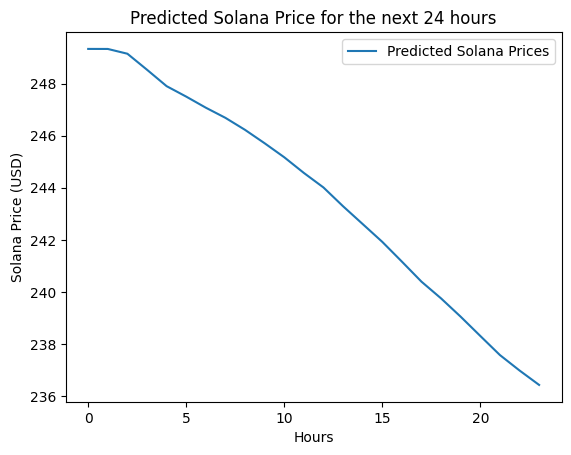

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def fetch_sol_price_data(start_date="2023-11-24", end_date="2024-11-24", interval="1h"):
    df = yf.download("SOL-USD", start=start_date, end=end_date, interval=interval)
    return df

def preprocess_data(df, time_step=24):
    scaler = MinMaxScaler(feature_range=(0, 1))
    price_scaled = scaler.fit_transform(df[['Close']].values)

    X, y = [], []
    for i in range(len(price_scaled) - time_step):
        X.append(price_scaled[i:i + time_step])
        y.append(price_scaled[i + time_step])

    X, y = np.array(X), np.array(y)

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, X_test, y_train, y_test, scaler

def build_tcn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model


def train_model(X_train, y_train, X_test, y_test):
    model = build_tcn_model(X_train.shape[1:])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
    return model

def predict_price(model, X_test, scaler, future_hours=24):
    predictions = model.predict(X_test)

    predictions = predictions.reshape(-1, 1)  # Ensure 2D (samples, 1)
    predictions = scaler.inverse_transform(predictions)

    last_data_point = X_test[-1]
    future_predictions = []

    for _ in range(future_hours):
        pred = model.predict(last_data_point.reshape(1, -1, 1))
        future_predictions.append(pred)

        last_data_point = np.append(last_data_point[1:], pred, axis=0)

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions


df = fetch_sol_price_data()
print(df.head())

X_train, X_test, y_train, y_test, scaler = preprocess_data(df)

model = train_model(X_train, y_train, X_test, y_test)

future_hours = 24
predictions = predict_price(model, X_test, scaler, future_hours=future_hours)

plt.plot(predictions, label='Predicted Solana Prices')
plt.title(f"Predicted Solana Price for the next {future_hours} hours")
plt.xlabel("Hours")
plt.ylabel("Solana Price (USD)")
plt.legend()
plt.show()

